# Pong RL DQN implementation

Teaching a machine to play an Atari game PONG using reinforcement learning, code adapted from TF-Agents tutorials and (Geron 2019).

References:

    - Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. A. (2013). Playing atari with deep reinforcement learning CoRR, abs/1312.5602. Retrieved from http://arxiv.org/abs/1312.5602
    - Geron, A. (2019). Hands-on machine learning with scikit-learn, keras, and tensorflow: Concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly UK Ltd.
    - Sutton, R. S., & Barto, A. G. (2018). Reinforcement Learning: An Introduction (2nd ed.). Cambridge: MIT Press.
    - Lillicrap, T., P., Hunt, J., Pritzel, A.,Heess, N., Erez, T., Tassa, Y., Silver, D., Wierstra, D. (2016 ) Continuous control with deep reinforcement learning. Retrieved from http://arxiv.org/abs/1509.02971 
    - Zhang, S., & Sutton, R. S. (2017). A Deeper Look at Experience Replay. Retrieved from https://arxiv.org/abs/1712.01275
    - IUBH. (2020). Reinforcement Learning DLMAIRIL01. Erfurt: IUBH.
    - Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., . . . Ostrovski, G. (2015). Humanlevel control through deep reinforcement learning. Nature, 518(7540):529–533.
    - Fedus, W., Ramachandran, P., Agarwal, R., Bengio, Y., Larochelle, H., Rowland, M., & Dabney, W. (2020). Revisiting Fundamentals of Experience Replay. Proceedings of Machine Learning Research, ISSN: 2640-3498.
        


In [30]:
## import basic libraries:
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from gym.wrappers import TimeLimit

from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4
from tf_agents.utils import common
from tf_agents.metrics import tf_metrics
from tf_agents.metrics import py_metrics
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.eval.metric_utils import log_metrics
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.trajectories.trajectory import to_transition
from tf_agents.utils.common import function
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks.q_network import QNetwork


## Environment

In [31]:
# stable and repeatable runs:
np.random.seed(42)
tf.random.set_seed(42)

# load the atari environment
max_episode_frames = 108000 
env_name = "PongNoFrameskip-v4"

env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames/4,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

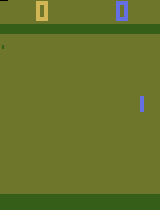

In [32]:
env.reset()
PIL.Image.fromarray(env.render())

In [33]:
# to make the environment usable from within TF graph
from tf_agents.environments.tf_py_environment import TFPyEnvironment
tf_env = TFPyEnvironment(env)

## DQN

In [34]:
# Q-Network, DQN

preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

## Agent & epsilon-greedy function

In [35]:
# switch the optimizer & loss function by commenting/uncommenting optimizer & td_errors_loss_fn

train_step = tf.Variable(0)
update_period = 4 
learning_rate = 2.5e-4
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) # uncomment/comment
#optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0, epsilon=0.00001, centered=True) # uncomment/comment

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, 
    decay_steps=150000 // update_period, 
    end_learning_rate=0.01) 

agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, 
                 td_errors_loss_fn=common.element_wise_squared_loss,       # uncomment/comment
                 #td_errors_loss_fn=keras.losses.Huber(reduction="none"),  # uncomment/comment
                 gamma=0.99, 
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))

agent.initialize()

## Replay buffer

In [39]:

replay_buffer_max_length = 100000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)

replay_buffer_observer = replay_buffer.add_batch

In [41]:
# Show progress class

class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

# fill the replay buffer with random data
initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) 
final_time_step, final_policy_state = init_driver.run()

20000/20000

## Metrics

In [10]:
# create training metrics, using TF-agents 

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

## Collect Policy

In [40]:
#Create the Collect Driver, passes current time step to the collect policy, which returns the action step

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) 

## Create the Dataset

In [9]:
# create the data set from replay buffer

dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


## Training Loop

In [28]:
# convert the main functions to TF functions

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy()), end="")
        if iteration % 500 == 0:
            logg=[]
            for a in train_metrics:
                logg = np.round(np.append(logg, np.asscalar(a.result().numpy())),2)
            f=open('DQN.txt','ab')
            np.savetxt(f, [logg], delimiter=",", fmt='%.1f')
            f.close()
            print(np.round(logg,1))


In [38]:
train_agent(n_iterations=500) # use 200000 or more here. 500 is just for tidy outcome

0 loss:0.03892[  0. 296.   0.   0.]
499 loss:0.00085

## Create visualisation with the trained deployment policy

In [20]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [21]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(1)
        prev_lives = lives

# access the deployment policy
watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)

final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

1000/1000

In [22]:
# save the animated gif

image_path = os.path.join("pong.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:500]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=60,
                     loop=0)